# Linear Regression Assignment 

## Introduction
For this assignment, we are going to explore data from activity trackers. Activity trackers are applications that track your activity using your smartphone, a smartwatch, wrist band or a clip-on device. Popular applications include Steps (iPhone), Apple Watch, Fitbit and Jawbone. For a study in France, over 900 volunteers received a Fitbit Zip (a clip-on activity tracker) and recorded their daily steps, distance and calories. 

In [201]:
import seaborn as sns #this is the plotting library I'll be using 
import pandas as pd #"as pd" means that we can use the abbreviation in commands
import matplotlib.pyplot as plt #we need Matplotlib for setting the labels in the Seaborn graphs
import numpy as np

## Read & Merge files
We will merge the csv files on the 'id'-row, since both datasets use it. 
Also, by using `sep=None`, pandas will automatically recognize the seperator. 


In [202]:
df1= pd.read_csv('survey.csv', encoding='UTF-8')
df2 = pd.read_csv('steps.csv', encoding='UTF-8', sep=None, engine='python')

df = pd.merge(df1, df2, on = 'id')


df['weight'].value_counts() #Get all the values. This may be less useful when there are many values.

72.0     40
65.0     35
73.0     32
80.0     31
55.0     31
         ..
128.0     1
116.0     1
102.0     1
101.0     1
105.0     1
Name: weight, Length: 72, dtype: int64

## Data Cleaning

We will remove unlikely values, ex. `weight > 200kg`  or  `weight < 30kg` if these are true, the entire row will be set to NaN.

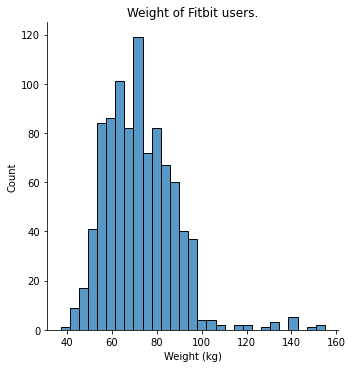

In [203]:
df['weight'] = df['weight'].apply(pd.to_numeric, errors='coerce')

def above_200(weight):
    if(weight > 200.0): 
        return float('NaN')
    else: 
        return weight
    
def below_30(weight):
    if(weight < 30.0):
        return float('NaN')
    else: 
        return weight
    
df['weight'] = df['weight'].apply(above_200)
df['weight'] = df['weight'].apply(below_30)


sns.displot(df['weight'].dropna(), kde=False) #Selecting the rating column. I need to drop the NA's for the plot
plt.title('Weight of Fitbit users.')
plt.xlabel('Weight (kg)')
plt.ylabel('Count')
plt.show()

## Feature Engineering
I want to calculate a bmi score for each participant in order to see how healthy they really are. There are however a couple of caviats. We don't have an accurate age, so we have to generalize it. Also, bmi scores are not representitive if the participant is pregnant, very muscular or is of Asian descent. 

To combat the the first issue I will take the middle of the age categories. 

The formula to calculate bmi is `weight / height²`. Weight in kg, Height in m.
The value this outputs can than be used in combination with the participant's age in order to give them a health score.

In [204]:
def average_age(age):
    if age == '<25':
        return 20
    elif age == '25-34':
        return 30
    elif age == '35-44':
        return 40
    elif age == '45-54':
        return 50
    elif age == '55-64':
        return 60
    elif age == '65-74':
        return 70
    elif age == '75-84':
        return 80

def bmi_value(bmi_score):
    if bmi_score < 18.5:
        return 'underweight'
    elif bmi_score < 25.0:
        return 'healthy'
    elif bmi_score < 30.0:
        return 'overweight'
    elif bmi_score <= 35.0:
        return 'obese'
    elif bmi_score > 35.0:
        return 'extreme obese'



df['ave_age'] = df['age'].apply(average_age)
df['bmi_score'] = (df['weight'] / ((df['height'] / 100) * (df['height']) / 100))
df['bmi_value'] = df['bmi_score'].apply(bmi_value)
print(df.head())

   id         city  gender    age  hh_size  education          education_1  \
0   1     Bordeaux    Male  25-34        4          4  Master or doctorate   
1   2        Lille    Male  35-44        1          3             Bachelor   
2   3  Montpellier    Male  25-34        2          2  Master or doctorate   
3   4         Lyon    Male    <25        1          1             Bachelor   
4   5  Montpellier  Female  25-34        3          4             Bachelor   

   height  weight  20-6-2013  ...  7-5-2014  8-5-2014  9-5-2014  10-5-2014  \
0   178.0    98.0        NaN  ...       NaN       NaN       NaN        NaN   
1   180.0    77.0        NaN  ...       NaN       NaN       NaN        NaN   
2   180.0    83.0        NaN  ...       NaN       NaN    6227.0     4567.0   
3   178.0    80.0        NaN  ...       NaN       NaN       NaN        NaN   
4   167.0    61.0        NaN  ...       NaN       NaN       NaN        NaN   

   11-5-2014  12-5-2014  13-5-2014  ave_age  bmi_score   bmi_v

## Exploratory data analysis


   id         city  gender    age  hh_size  education          education_1  \
0   1     Bordeaux    Male  25-34        4          4  Master or doctorate   
1   2        Lille    Male  35-44        1          3             Bachelor   
2   3  Montpellier    Male  25-34        2          2  Master or doctorate   
3   4         Lyon    Male    <25        1          1             Bachelor   
4   5  Montpellier  Female  25-34        3          4             Bachelor   

   height  weight  ave_age  bmi_score   bmi_value          mspp  
0   178.0    98.0     30.0  30.930438       obese  10205.521212  
1   180.0    77.0     40.0  23.765432     healthy   5687.423313  
2   180.0    83.0     30.0  25.617284  overweight   8301.729730  
3   178.0    80.0     20.0  25.249337  overweight   3633.200000  
4   167.0    61.0     30.0  21.872423     healthy   5312.129630  


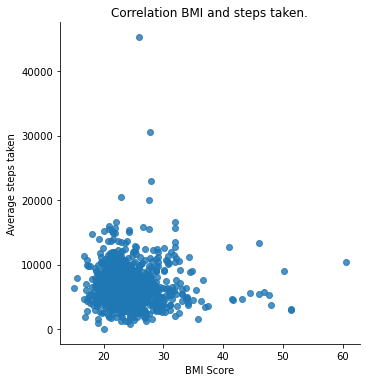

In [205]:
df['mspp'] = df.iloc[:, 10:337].mean(axis = 1)
df_sub = df
df_sub = df_sub.drop(df_sub.iloc[:, 9:337], axis=1)


def rem_mspp(mspp):
    if mspp > 50000.0:
        return float('NaN')
    else:
        return mspp


df_sub['mspp'] = df_sub['mspp'].apply(rem_mspp)
print(df_sub.head())
# sns.pairplot(df_sub)
# plt.show()

df_step_density = df.drop(columns=['city', 'gender', 'age', 'education_1', 'bmi_value'])

sns.lmplot(x="bmi_score", y="mspp", fit_reg=False, data=df_sub)
plt.xlabel('BMI Score') #use matplotlib to refine Seaborn plot
plt.ylabel('Average steps taken')
plt.title('Correlation BMI and steps taken.')
plt.show()



np.isnan(df["mspp"]).any()
np.isnan(df["bmi_score"]).any()

df["mspp"] = np.nan_to_num(df["mspp"])
df["bmi_score"] = np.nan_to_num(df["bmi_score"])
df["ave_age"] = np.nan_to_num(df["ave_age"])

In [206]:
from scipy.stats.stats import pearsonr #We will need the correlation function from the scientific package scipy



print(pearsonr(df['mspp'],df['bmi_score']))
print(pearsonr(df['mspp'],df['ave_age']))

(0.010631940195808865, 0.7462188666347227)
(0.01645426397972085, 0.6164580832987754)


In [ ]:
corr = df[['mspp', 'bmi_score', 'ave_age']].corr() #I'm leaving out the corrected variables (divided by 1 million)
corr